# Ensemble (XGBoost + CatBoost + LightGBM) prediction for road accident 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/train.csv')
test_df = pd.read_csv('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/test.csv')

print(train_df.info())
print("\nMissing values in train:", train_df.isnull().sum().sum())
print("Missing values in test:", test_df.isnull().sum().sum())

# basic statistics
print(train_df['accident_risk'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [3]:
def create_advanced_features(df):
    df_copy = df.copy()
    
    # Basic interactions from your original features
    df_copy['speed_curvature'] = df_copy['speed_limit'] * df_copy['curvature']
    df_copy['lanes_speed'] = df_copy['num_lanes'] * df_copy['speed_limit']
    
    # Risk encodings
    weather_risk = {'clear': 0, 'rainy': 1, 'foggy': 2}
    lighting_risk = {'daylight': 0, 'dim': 1, 'night': 2}
    time_risk = {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}
    
    df_copy['weather_risk'] = df_copy['weather'].map(weather_risk)
    df_copy['lighting_risk'] = df_copy['lighting'].map(lighting_risk)
    df_copy['time_risk'] = df_copy['time_of_day'].map(time_risk)
    
    # Combined risk score
    df_copy['environment_risk'] = df_copy['weather_risk'] + df_copy['lighting_risk'] + df_copy['time_risk']
    
    # Advanced features
    df_copy['complexity_score'] = (df_copy['curvature'] * df_copy['speed_limit'] * 
                                 df_copy['num_lanes']) / 100
    
    # Visibility risk (combination of lighting + weather)
    lighting_scores = {'daylight': 0, 'dim': 2, 'night': 3}
    weather_scores = {'clear': 0, 'rainy': 2, 'foggy': 3}
    df_copy['visibility_risk'] = (df_copy['lighting'].map(lighting_scores) + 
                                df_copy['weather'].map(weather_scores))
    
    # Time risk amplification
    time_scores = {'morning': 1, 'afternoon': 1.2, 'evening': 1.5, 'night': 2}
    df_copy['time_amplifier'] = df_copy['time_of_day'].map(time_scores)
    
    # Road type encoding
    road_scores = {'urban': 1, 'rural': 1.5, 'highway': 2}
    df_copy['road_type_encoded'] = df_copy['road_type'].map(road_scores)
    
    # Combined risk score
    df_copy['composite_risk'] = (
        df_copy['complexity_score'] * 
        df_copy['visibility_risk'] * 
        df_copy['time_amplifier'] * 
        df_copy['road_type_encoded']
    ) / 10
    
    # Peak hour flag
    df_copy['peak_hour'] = ((df_copy['time_of_day'].isin(['morning', 'evening'])) & 
                           (df_copy['holiday'] == 'False')).astype(int)
    
    # Dangerous combinations
    df_copy['high_risk_combo'] = (
        (df_copy['weather'].isin(['foggy', 'rainy'])) &
        (df_copy['lighting'].isin(['dim', 'night'])) &
        (df_copy['curvature'] > 0.5)
    ).astype(int)
    
    return df_copy

train_df = create_advanced_features(train_df)
test_df = create_advanced_features(test_df)
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (517754, 27), Test shape: (172585, 26)


In [4]:
# Updated features list with advanced features
features_to_use = [
    'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 
    'weather', 'road_signs_present', 'public_road', 'time_of_day', 
    'holiday', 'school_season', 'num_reported_accidents',
    'speed_curvature', 'lanes_speed', 'weather_risk', 
    'lighting_risk', 'time_risk', 'environment_risk',
    'complexity_score', 'visibility_risk', 'time_amplifier',
    'road_type_encoded', 'composite_risk', 'peak_hour', 'high_risk_combo'
]

X = train_df[features_to_use]
y = train_df['accident_risk']
X_test = test_df[features_to_use]

# Identifying categorical features for CatBoost
categorical_features = [
    'road_type', 'lighting', 'weather', 'road_signs_present', 
    'public_road', 'time_of_day', 'holiday', 'school_season'
]

# Converting boolean columns to strings for proper handling
for col in ['road_signs_present', 'public_road', 'holiday', 'school_season']:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print(f"Total features: {len(features_to_use)}")
print(f"Categorical features: {categorical_features}")

Total features: 25
Categorical features: ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']


In [5]:
def prepare_xgboost_features_simple(X, X_test=None):
    """Simpler version - converting everything to numeric"""
    X_xgb = X.copy()
    
    if X_test is not None:
        X_test_xgb = X_test.copy()
    else:
        X_test_xgb = None
    
    # Converting all categorical columns using label encoding
    categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day', 
                       'road_signs_present', 'public_road', 'holiday', 'school_season']
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_xgb[col] = le.fit_transform(X_xgb[col].astype(str))
        if X_test is not None:
            # Handling unseen labels in test set
            unique_train = set(le.classes_)
            X_test_xgb[col] = X_test_xgb[col].astype(str).apply(
                lambda x: le.transform([x])[0] if x in unique_train else -1
            )
    
    if X_test is not None:
        return X_xgb, X_test_xgb
    return X_xgb

In [6]:
from lightgbm import LGBMRegressor

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

# Preparing data for all models
X_train_cat = X_train.copy()
X_val_cat = X_val.copy()
X_test_cat = X_test.copy()

# Preparing XGBoost features (label encoded)
X_train_xgb, X_val_xgb = prepare_xgboost_features_simple(X_train, X_val)
X_test_xgb = prepare_xgboost_features_simple(X_test)

# For LightGBM model
X_train_lgb, X_val_lgb = prepare_xgboost_features_simple(X_train, X_val)
X_test_lgb = prepare_xgboost_features_simple(X_test)

# CatBoost model
cat_model = CatBoostRegressor(
    cat_features=categorical_features,
    random_state=42,
    verbose=False,
    iterations=800,  
    learning_rate=0.03,  
    depth=8,  
    l2_leaf_reg=3,  
    random_strength=0.5, 
    bagging_temperature=0.8,  
    early_stopping_rounds=50
)

# XGBoost model
xgb_model = XGBRegressor(
    random_state=42,
    n_estimators=800,  
    learning_rate=0.03,
    max_depth=8, 
    subsample=0.85,  
    colsample_bytree=0.8,
    colsample_bylevel=0.8,  
    reg_alpha=0.2,  
    reg_lambda=0.3,  
    gamma=0.1,  
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbosity=0  
)

# LightGBM model
lgb_model = LGBMRegressor(
    random_state=42,
    n_estimators=800,  
    learning_rate=0.03,  
    max_depth=8,  
    num_leaves=45,  
    subsample=0.85,  
    colsample_bytree=0.8,
    reg_alpha=0.2,  
    reg_lambda=0.3,  
    min_child_samples=25,  
    min_child_weight=0.001, 
    verbose=-1
)


# Model training
print("Training models...")

print("Training CatBoost...", end=" ")
cat_model.fit(X_train_cat, y_train, eval_set=[(X_val_cat, y_val)], verbose=False)
print("✓")

print("Training XGBoost...", end=" ")
xgb_model.fit(X_train_xgb, y_train, eval_set=[(X_val_xgb, y_val)], verbose=False)
print("✓")

print("Training LightGBM...", end=" ")
lgb_model.fit(X_train_lgb, y_train)
print("✓")

print("\nAll models trained successfully!")

# Predictions
cat_val_pred = cat_model.predict(X_val_cat)
xgb_val_pred = xgb_model.predict(X_val_xgb)
lgb_val_pred = lgb_model.predict(X_val_lgb)

cat_test_pred = cat_model.predict(X_test_cat)
xgb_test_pred = xgb_model.predict(X_test_xgb)
lgb_test_pred = lgb_model.predict(X_test_lgb)

print("Predictions ready for ensemble!")

Training samples: 414203
Validation samples: 103551
Training models...
Training CatBoost... ✓
Training XGBoost... ✓
Training LightGBM... ✓

All models trained successfully!
Predictions ready for ensemble!


In [7]:
from sklearn.linear_model import Ridge

print("Creating stacking ensemble...")

# Getting predictions from all models
cat_train_pred = cat_model.predict(X_train_cat)
cat_val_pred = cat_model.predict(X_val_cat)
cat_test_pred = cat_model.predict(X_test_cat)

xgb_train_pred = xgb_model.predict(X_train_xgb)
xgb_val_pred = xgb_model.predict(X_val_xgb)
xgb_test_pred = xgb_model.predict(X_test_xgb)

lgb_train_pred = lgb_model.predict(X_train_lgb)
lgb_val_pred = lgb_model.predict(X_val_lgb)
lgb_test_pred = lgb_model.predict(X_test_lgb)

# Create stacking features (use all 3 models)
level1_train = np.column_stack([cat_train_pred, xgb_train_pred, lgb_train_pred])
level1_val = np.column_stack([cat_val_pred, xgb_val_pred, lgb_val_pred])
level1_test = np.column_stack([cat_test_pred, xgb_test_pred, lgb_test_pred])

print(f"Stacking feature shapes:")
print(f"Train: {level1_train.shape}")
print(f"Val: {level1_val.shape}") 
print(f"Test: {level1_test.shape}")

# Train meta-model
meta_model = Ridge(alpha=0.1)
meta_model.fit(level1_train, y_train)

# Make stacking predictions
stacking_val_pred = meta_model.predict(level1_val)
stacking_test_pred = meta_model.predict(level1_test)

print("Stacking ensemble training completed!")

Creating stacking ensemble...
Stacking feature shapes:
Train: (414203, 3)
Val: (103551, 3)
Test: (172585, 3)
Stacking ensemble training completed!


In [8]:
# Calculate individual model performances with multiple metrics
cat_val_rmse = np.sqrt(mean_squared_error(y_val, cat_val_pred))
xgb_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_pred))
lgb_val_rmse = np.sqrt(mean_squared_error(y_val, lgb_val_pred))
stack_val_rmse = np.sqrt(mean_squared_error(y_val, stacking_val_pred))

cat_mae = mean_absolute_error(y_val, cat_val_pred)
xgb_mae = mean_absolute_error(y_val, xgb_val_pred)
lgb_mae = mean_absolute_error(y_val, lgb_val_pred)

# Combined score (RMSE + MAE)
def combined_score(rmse, mae):
    return 0.7 * rmse + 0.3 * mae  # Weight RMSE more heavily

cat_score = combined_score(cat_val_rmse, cat_mae)
xgb_score = combined_score(xgb_val_rmse, xgb_mae)
lgb_score = combined_score(lgb_val_rmse, lgb_mae)
stack_score = combined_score(stack_val_rmse, 0)

# Performance-based weights with exponential decay (better models get much higher weight)
models_scores = {
    'CatBoost': cat_score,
    'XGBoost': xgb_score,
    'LightGBM': lgb_score,
    'Stacking': stack_score
}

# Exponential weighting (emphasizes differences between models)
weights = {}
total_weight = 0
for name, score in models_scores.items():
    weights[name] = np.exp(-score * 5) 
    total_weight += weights[name]

# Normalize weights
for name in weights:
    weights[name] /= total_weight

print("\nSmart Model Weights:")
for name, weight in weights.items():
    print(f"{name}: {weight:.3f}")

# Super ensemble with smart weighting
super_ensemble_val = (
    weights['CatBoost'] * cat_val_pred +
    weights['XGBoost'] * xgb_val_pred +
    weights['LightGBM'] * lgb_val_pred +
    weights['Stacking'] * stacking_val_pred
)

super_ensemble_test = (
    weights['CatBoost'] * cat_test_pred +
    weights['XGBoost'] * xgb_test_pred +
    weights['LightGBM'] * lgb_test_pred +
    weights['Stacking'] * stacking_test_pred
)


Smart Model Weights:
CatBoost: 0.246
XGBoost: 0.246
LightGBM: 0.246
Stacking: 0.262


In [9]:
super_ensemble_val_rmse = np.sqrt(mean_squared_error(y_val, super_ensemble_val))
super_ensemble_val_mae = mean_absolute_error(y_val, super_ensemble_val)

print(f"\n=== SUPER ENSEMBLE PERFORMANCE ===")
print(f"Super Ensemble RMSE: {super_ensemble_val_rmse:.4f}")
print(f"Super Ensemble MAE: {super_ensemble_val_mae:.4f}")

# Individual model performance for comparison
print(f"\nCatBoost RMSE: {cat_val_rmse:.4f}")
print(f"XGBoost RMSE: {xgb_val_rmse:.4f}")
print(f"LightGBM RMSE: {lgb_val_rmse:.4f}")
print(f"Stacking RMSE: {stack_val_rmse:.4f}")

# Calculating improvement
improvement = ((min(cat_val_rmse, xgb_val_rmse) - super_ensemble_val_rmse) / 
               min(cat_val_rmse, xgb_val_rmse) * 100)
print(f"Improvement over best single model: {improvement:.4f}%")


=== SUPER ENSEMBLE PERFORMANCE ===
Super Ensemble RMSE: 0.0563
Super Ensemble MAE: 0.0437

CatBoost RMSE: 0.0563
XGBoost RMSE: 0.0564
LightGBM RMSE: 0.0563
Stacking RMSE: 0.0565
Improvement over best single model: 0.0962%


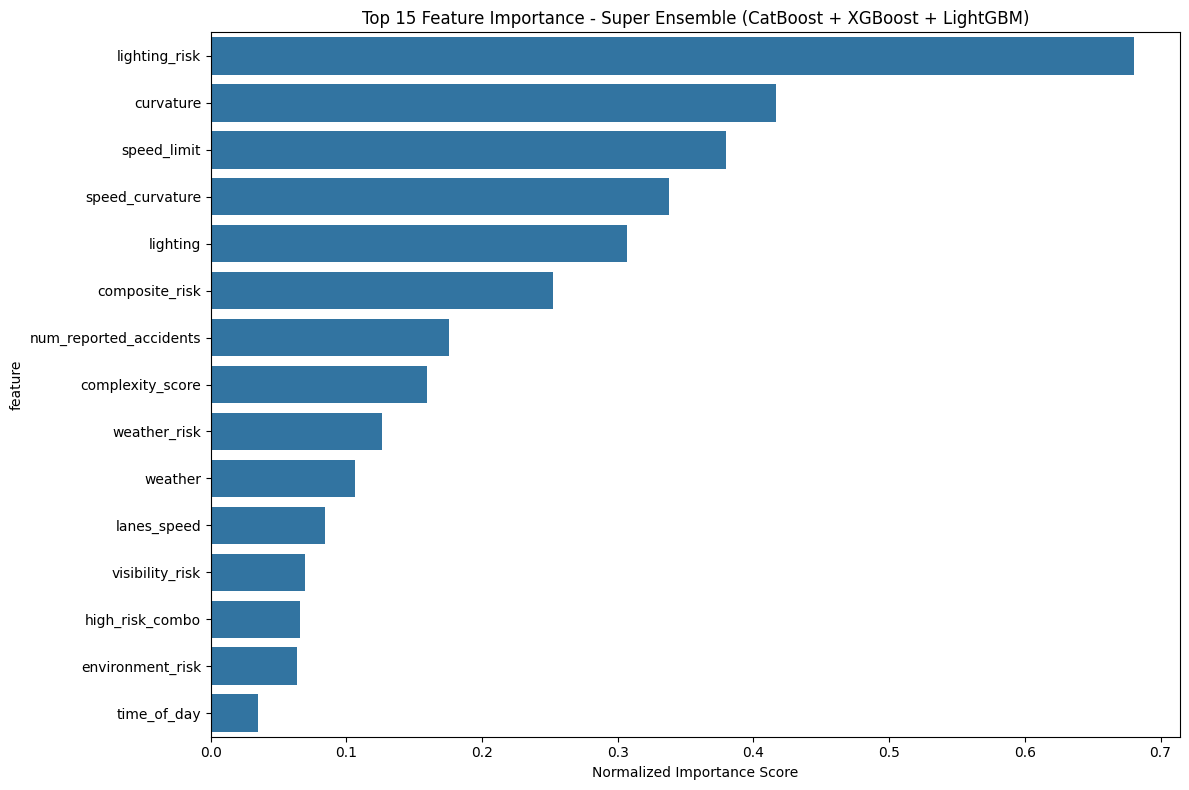

                      Super Ensemble Feature Importance               
                   feature  importance_avg  importance_cat  importance_xgb  \
15           lighting_risk        0.680332        1.000000        1.000000   
2                curvature        0.416669        0.214884        0.035124   
3              speed_limit        0.379487        0.719074        0.142254   
12         speed_curvature        0.338020        0.038576        0.293462   
4                 lighting        0.306585        0.002043        0.734648   
22          composite_risk        0.252493        0.001398        0.115799   
11  num_reported_accidents        0.175227        0.101820        0.026574   
18        complexity_score        0.159039        0.001064        0.031507   
14            weather_risk        0.126106        0.261158        0.036509   
5                  weather        0.106391        0.002970        0.060836   

    importance  
15    0.040996  
2     1.000000  
3     0.277132  
12

In [10]:
# LightGBM importance
lgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
})
lgb_importance['importance'] = lgb_importance['importance'] / lgb_importance['importance'].max()

cat_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': cat_model.get_feature_importance()
})
cat_importance['importance'] = cat_importance['importance'] / cat_importance['importance'].max()

xgb_importance = pd.DataFrame({
    'feature': X.columns, 
    'importance': xgb_model.feature_importances_
})
xgb_importance['importance'] = xgb_importance['importance'] / xgb_importance['importance'].max()

# Combining all three models
combined_importance = pd.merge(
    pd.merge(cat_importance, xgb_importance, on='feature', suffixes=('_cat', '_xgb')),
    lgb_importance, on='feature'
)
combined_importance['importance_avg'] = (
    combined_importance['importance_cat'] + 
    combined_importance['importance_xgb'] + 
    combined_importance['importance']
) / 3
combined_importance = combined_importance.sort_values('importance_avg', ascending=False)

# Plotting combined importance
plt.figure(figsize=(12, 8))
sns.barplot(data=combined_importance.head(15), x='importance_avg', y='feature')
plt.title('Top 15 Feature Importance - Super Ensemble (CatBoost + XGBoost + LightGBM)')
plt.xlabel('Normalized Importance Score')
plt.tight_layout()
plt.show()

print("                      Super Ensemble Feature Importance               ")
print(combined_importance.head(10)[['feature', 'importance_avg', 'importance_cat', 'importance_xgb', 'importance']])

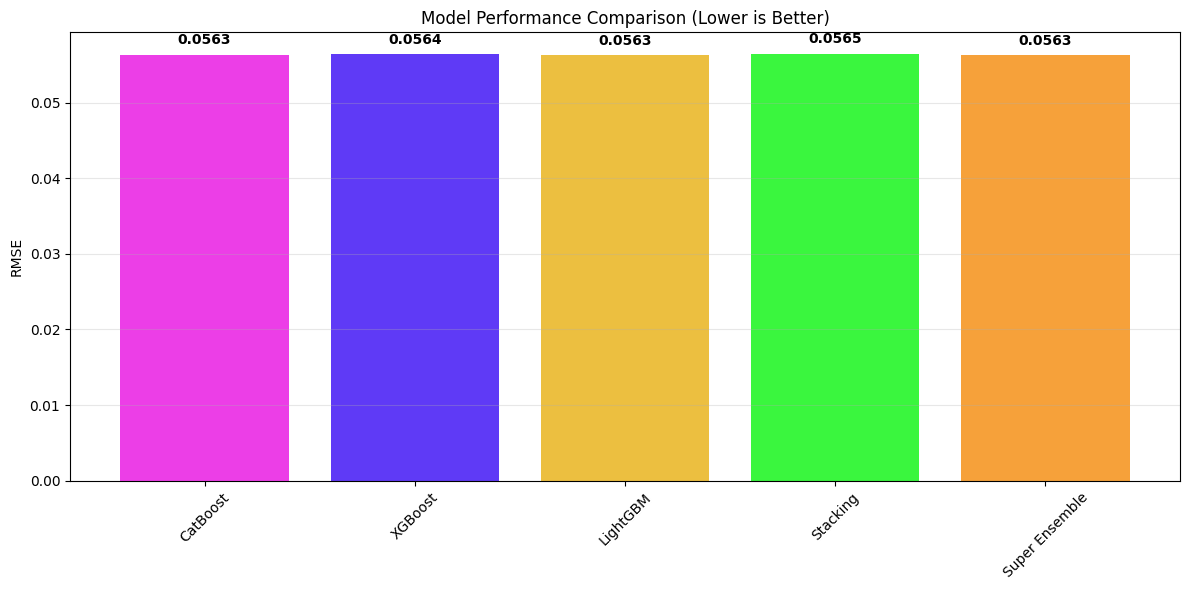

In [11]:
models_performance = {
    'CatBoost': cat_val_rmse,
    'XGBoost': xgb_val_rmse,
    'LightGBM': lgb_val_rmse,
    'Stacking': stack_val_rmse,
    'Super Ensemble': super_ensemble_val_rmse
}

plt.figure(figsize=(12, 6))
colors = ["#E80EE1", "#3708F4", "#E8AF10", "#09F40D", "#F48A08"]
plt.bar(models_performance.keys(), models_performance.values(), color=colors, alpha=0.8)
plt.ylabel('RMSE')
plt.title('Model Performance Comparison (Lower is Better)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# Adding value labels on bars
for i, (model, rmse) in enumerate(models_performance.items()):
    plt.text(i, rmse + 0.001, f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

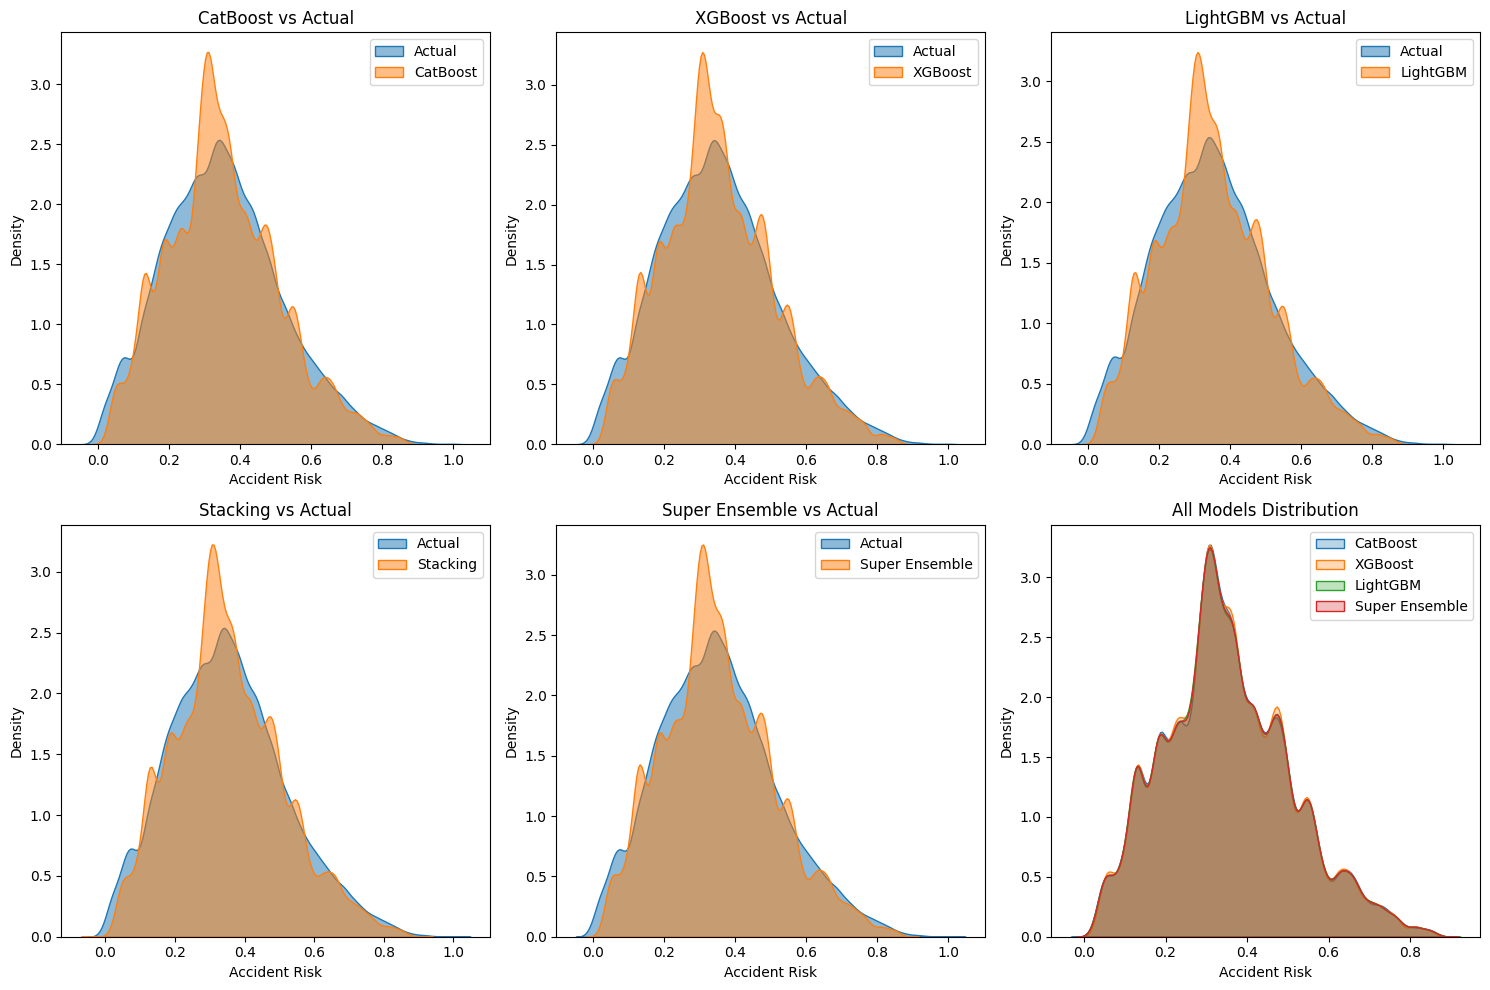

In [12]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(cat_val_pred, label='CatBoost', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('CatBoost vs Actual')
plt.legend()

plt.subplot(2, 3, 2)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(xgb_val_pred, label='XGBoost', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('XGBoost vs Actual')
plt.legend()

plt.subplot(2, 3, 3)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(lgb_val_pred, label='LightGBM', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('LightGBM vs Actual')
plt.legend()

plt.subplot(2, 3, 4)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(stacking_val_pred, label='Stacking', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('Stacking vs Actual')
plt.legend()

plt.subplot(2, 3, 5)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(super_ensemble_val, label='Super Ensemble', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('Super Ensemble vs Actual')
plt.legend()

plt.subplot(2, 3, 6)
sns.kdeplot(cat_val_pred, label='CatBoost', fill=True, alpha=0.3)
sns.kdeplot(xgb_val_pred, label='XGBoost', fill=True, alpha=0.3)
sns.kdeplot(lgb_val_pred, label='LightGBM', fill=True, alpha=0.3)
sns.kdeplot(super_ensemble_val, label='Super Ensemble', fill=True, alpha=0.3)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('All Models Distribution')
plt.legend()

plt.tight_layout()
plt.show()

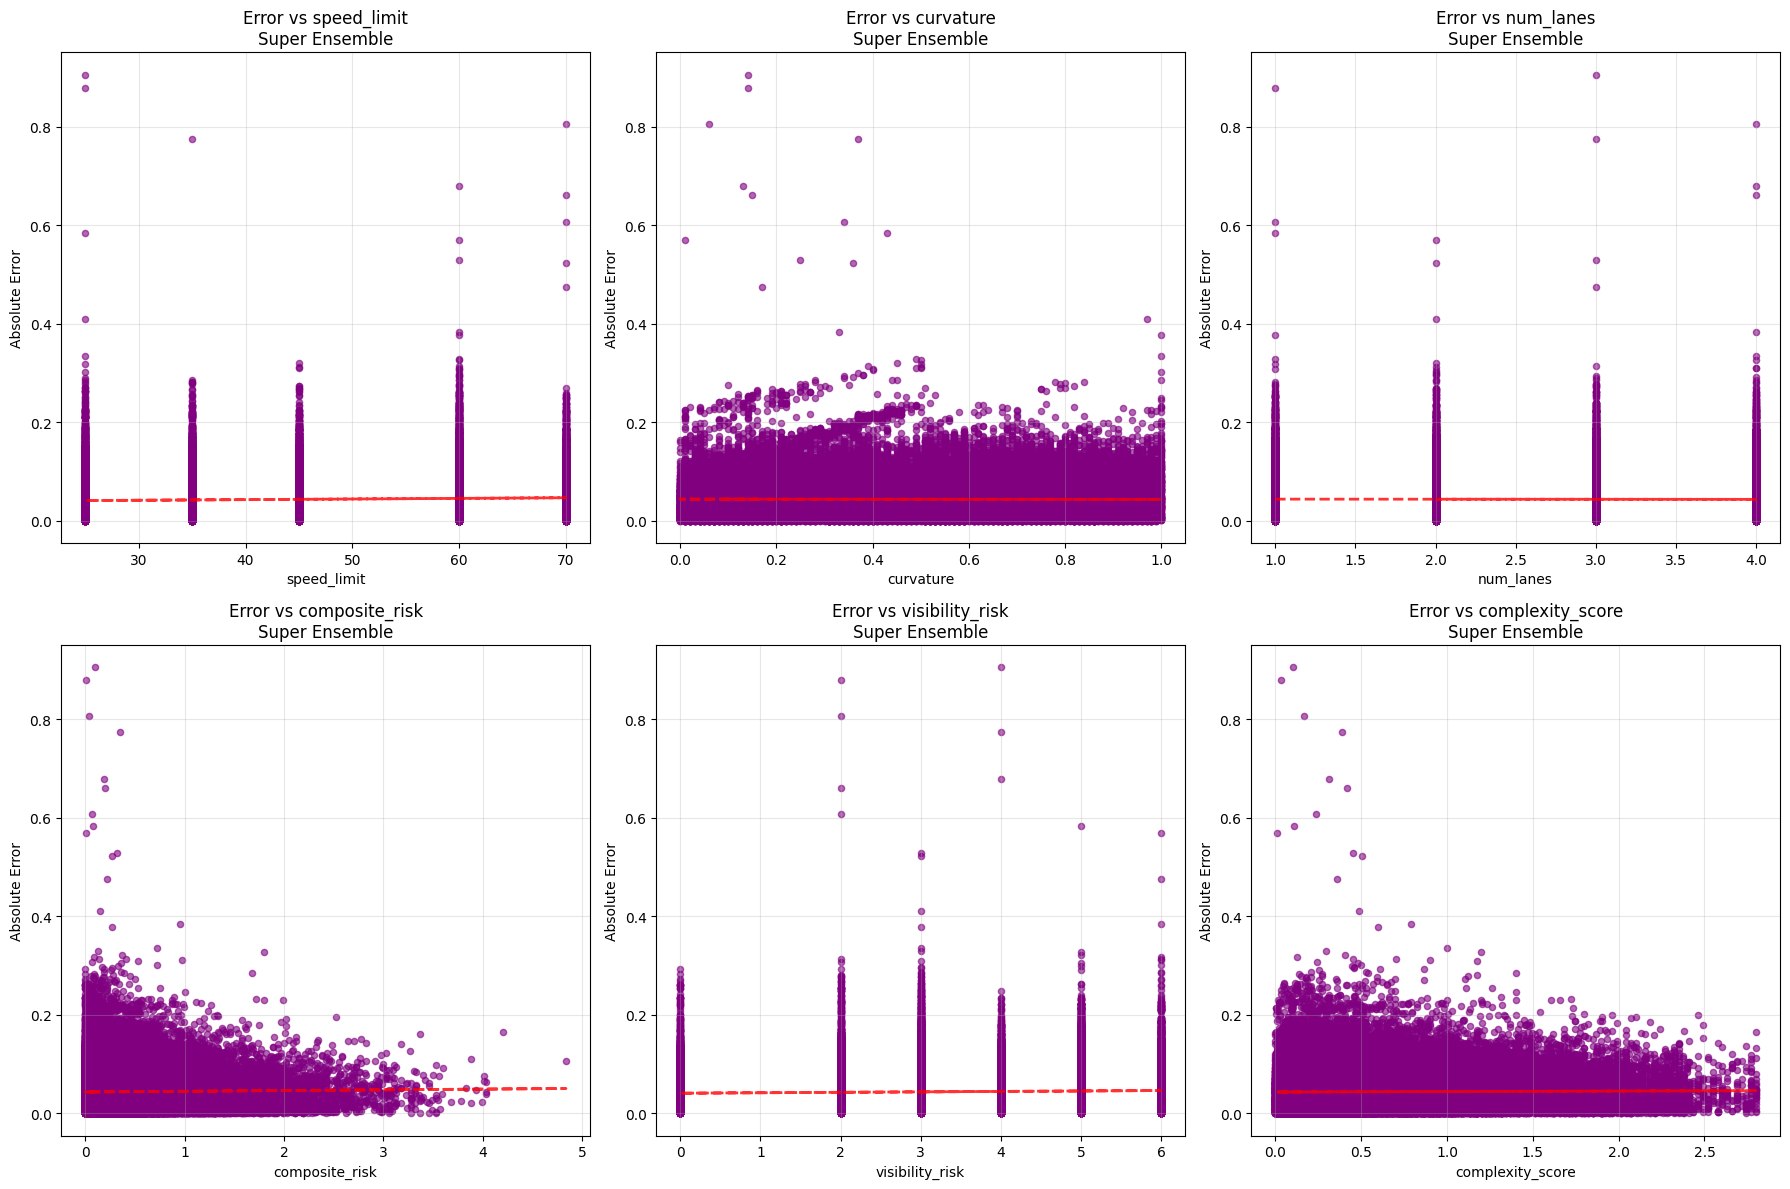

The red horizontal line in the plot is a trend line (linear regression line) that shows the relationship between feature values and prediction errors.



Error Analysis Summary:

speed_limit - Mean Absolute Error by range:
  (24.955, 36.25]: 0.0419
  (36.25, 47.5]: 0.0418
  (47.5, 58.75]: nan
  (58.75, 70.0]: 0.0468

curvature - Mean Absolute Error by range:
  (-0.001, 0.25]: 0.0435
  (0.25, 0.5]: 0.0444
  (0.5, 0.75]: 0.0438
  (0.75, 1.0]: 0.0429

num_lanes - Mean Absolute Error by range:
  (0.997, 1.75]: 0.0440
  (1.75, 2.5]: 0.0436
  (2.5, 3.25]: 0.0438
  (3.25, 4.0]: 0.0434


In [13]:
# Error analysis by important features
feature_analysis_df = pd.DataFrame({
    'actual': y_val,
    'predicted': super_ensemble_val,  
    'error': super_ensemble_val - y_val, 
    'abs_error': np.abs(super_ensemble_val - y_val) 
})

# Addding important features for analysis (using advanced features)
important_features = ['speed_limit', 'curvature', 'num_lanes', 'composite_risk', 'visibility_risk', 'complexity_score']
for feature in important_features:
    if feature in X_val.columns:
        feature_analysis_df[feature] = X_val[feature].values
    else:
        print(f"Warning: {feature} not found in features, using fallback")
        # Fallback to basic features if advanced ones are missing
        important_features = ['speed_limit', 'curvature', 'num_lanes', 'weather_risk', 'time_risk', 'environment_risk']
        break

# Plotting error vs important features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(important_features[:6]):
    if feature in feature_analysis_df.columns:
        axes[i].scatter(feature_analysis_df[feature], feature_analysis_df['abs_error'], 
                       alpha=0.6, s=20, color='purple')
        # Adding trend line
        z = np.polyfit(feature_analysis_df[feature], feature_analysis_df['abs_error'], 1)
        p = np.poly1d(z)
        axes[i].plot(feature_analysis_df[feature], p(feature_analysis_df[feature]), 
                    "r--", alpha=0.8, linewidth=2)
        
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Absolute Error')
        axes[i].set_title(f'Error vs {feature}\nSuper Ensemble')
        axes[i].grid(alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'{feature} not available', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Missing: {feature}')

# Removing empty subplots
for i in range(len(important_features), 6):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

print("The red horizontal line in the plot is a trend line (linear regression line) that shows the relationship between feature values and prediction errors.")
print("\n")
# Print error statistics by feature ranges
print("\nError Analysis Summary:")
for feature in important_features[:3]:  # Shows top 3 features
    if feature in feature_analysis_df.columns:
        feature_analysis_df[f'{feature}_bin'] = pd.cut(feature_analysis_df[feature], bins=4)
        error_by_bin = feature_analysis_df.groupby(f'{feature}_bin')['abs_error'].mean()
        print(f"\n{feature} - Mean Absolute Error by range:")
        for bin_range, error in error_by_bin.items():
            print(f"  {bin_range}: {error:.4f}")

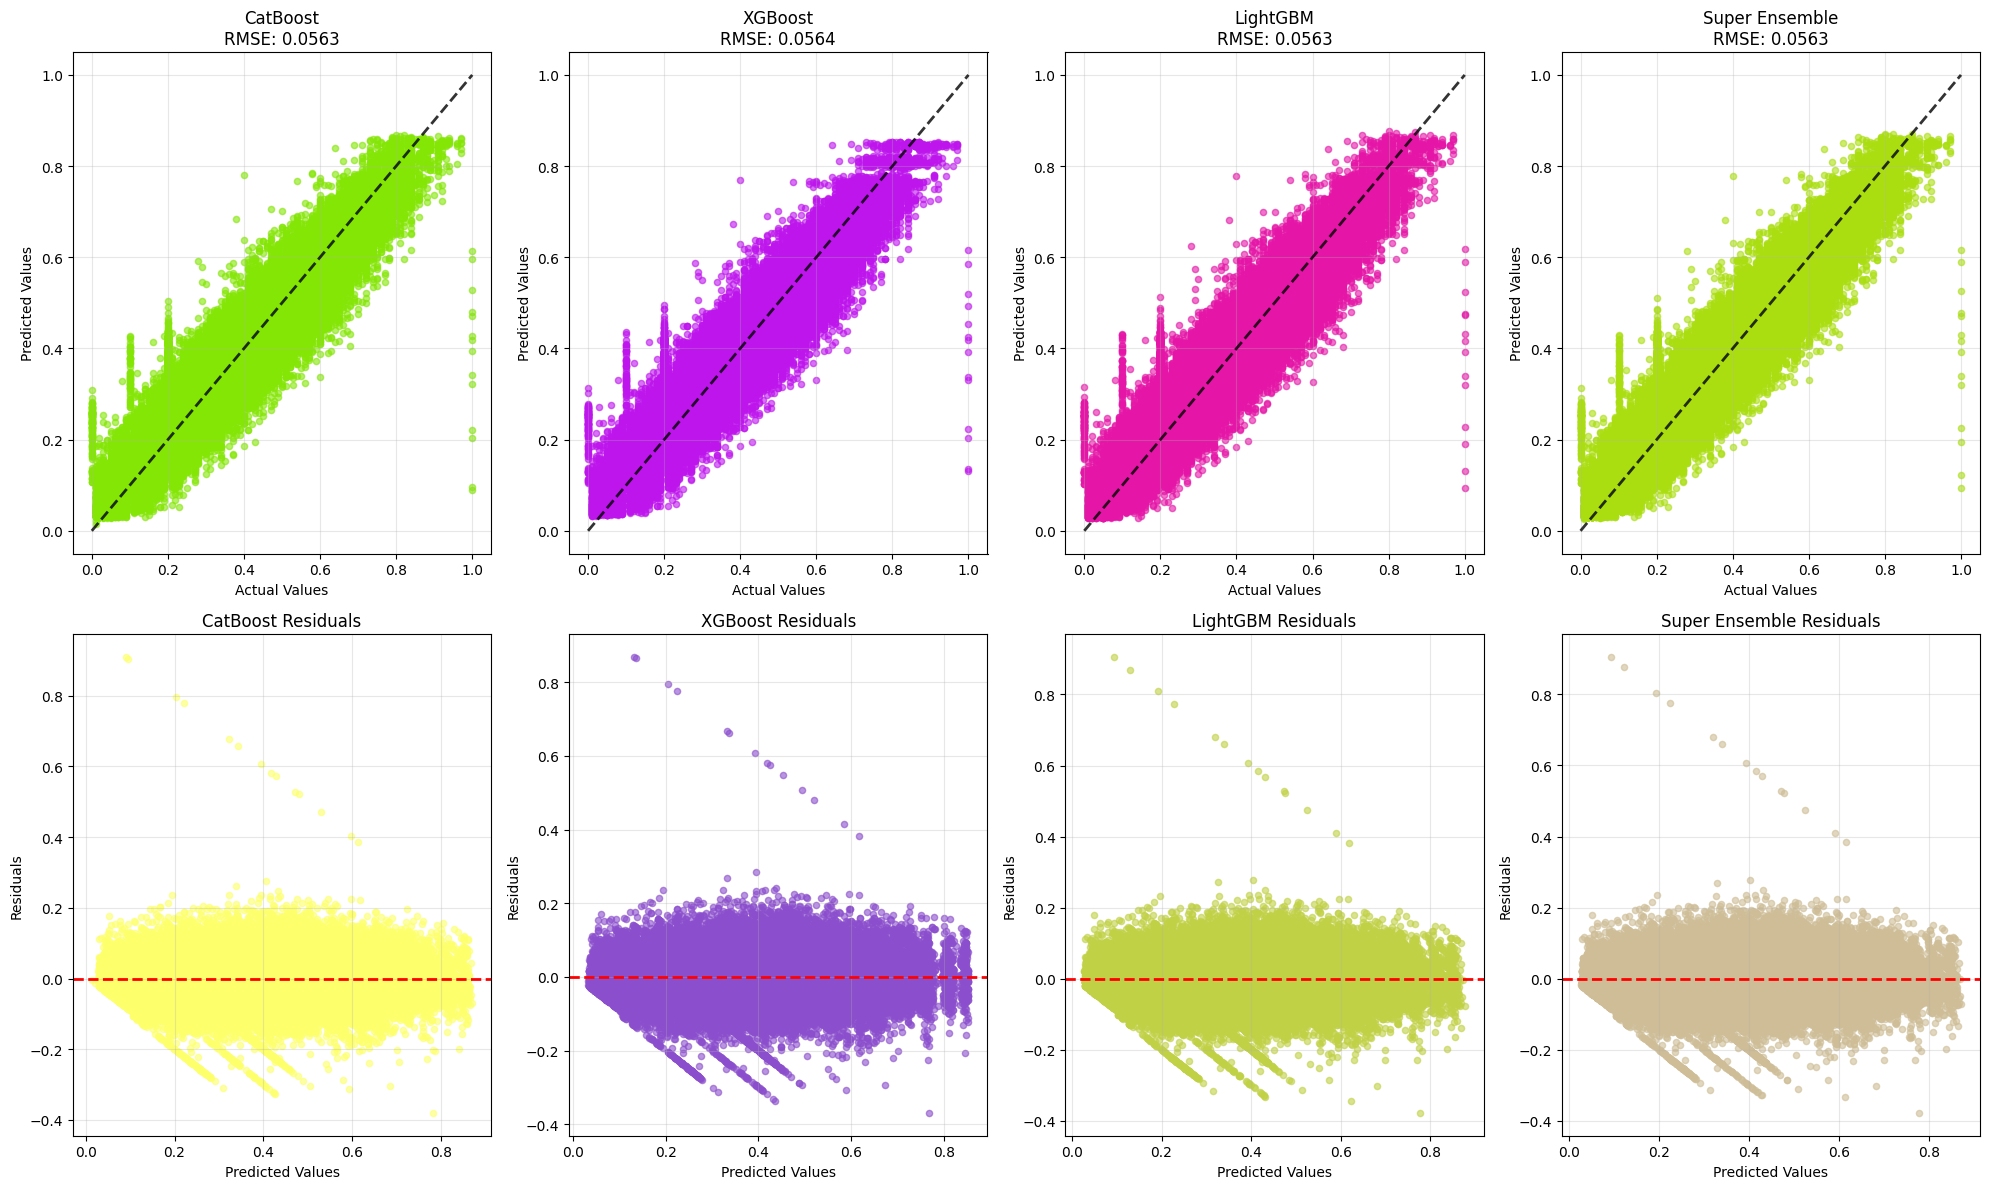

In [14]:
plt.figure(figsize=(20, 12))

# Row 1: Actual vs Predicted plots for all models
plt.subplot(2, 4, 1)
plt.scatter(y_val, cat_val_pred, alpha=0.6, label='CatBoost', s=20, color="#84E605")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'CatBoost\nRMSE: {cat_val_rmse:.4f}')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 2)
plt.scatter(y_val, xgb_val_pred, alpha=0.6, label='XGBoost', s=20, color="#BE15ED")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'XGBoost\nRMSE: {xgb_val_rmse:.4f}')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 3)
plt.scatter(y_val, lgb_val_pred, alpha=0.6, label='LightGBM', s=20, color="#E516A7")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'LightGBM\nRMSE: {lgb_val_rmse:.4f}')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 4)
plt.scatter(y_val, super_ensemble_val, alpha=0.6, label='Super Ensemble', s=20, color="#AADE10")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Super Ensemble\nRMSE: {super_ensemble_val_rmse:.4f}')
plt.grid(alpha=0.3)

# Row 2: Residual plots for all models
plt.subplot(2, 4, 5)
cat_residuals = y_val - cat_val_pred
plt.scatter(cat_val_pred, cat_residuals, alpha=0.6, s=20, color="#FDFF6B")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('CatBoost Residuals')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 6)
xgb_residuals = y_val - xgb_val_pred
plt.scatter(xgb_val_pred, xgb_residuals, alpha=0.6, s=20, color="#8B4ECD")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('XGBoost Residuals')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 7)
lgb_residuals = y_val - lgb_val_pred
plt.scatter(lgb_val_pred, lgb_residuals, alpha=0.6, s=20, color="#C1D145")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('LightGBM Residuals')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 8)
super_ensemble_residuals = y_val - super_ensemble_val
plt.scatter(super_ensemble_val, super_ensemble_residuals, alpha=0.6, s=20, color="#CEBD96")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Super Ensemble Residuals')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

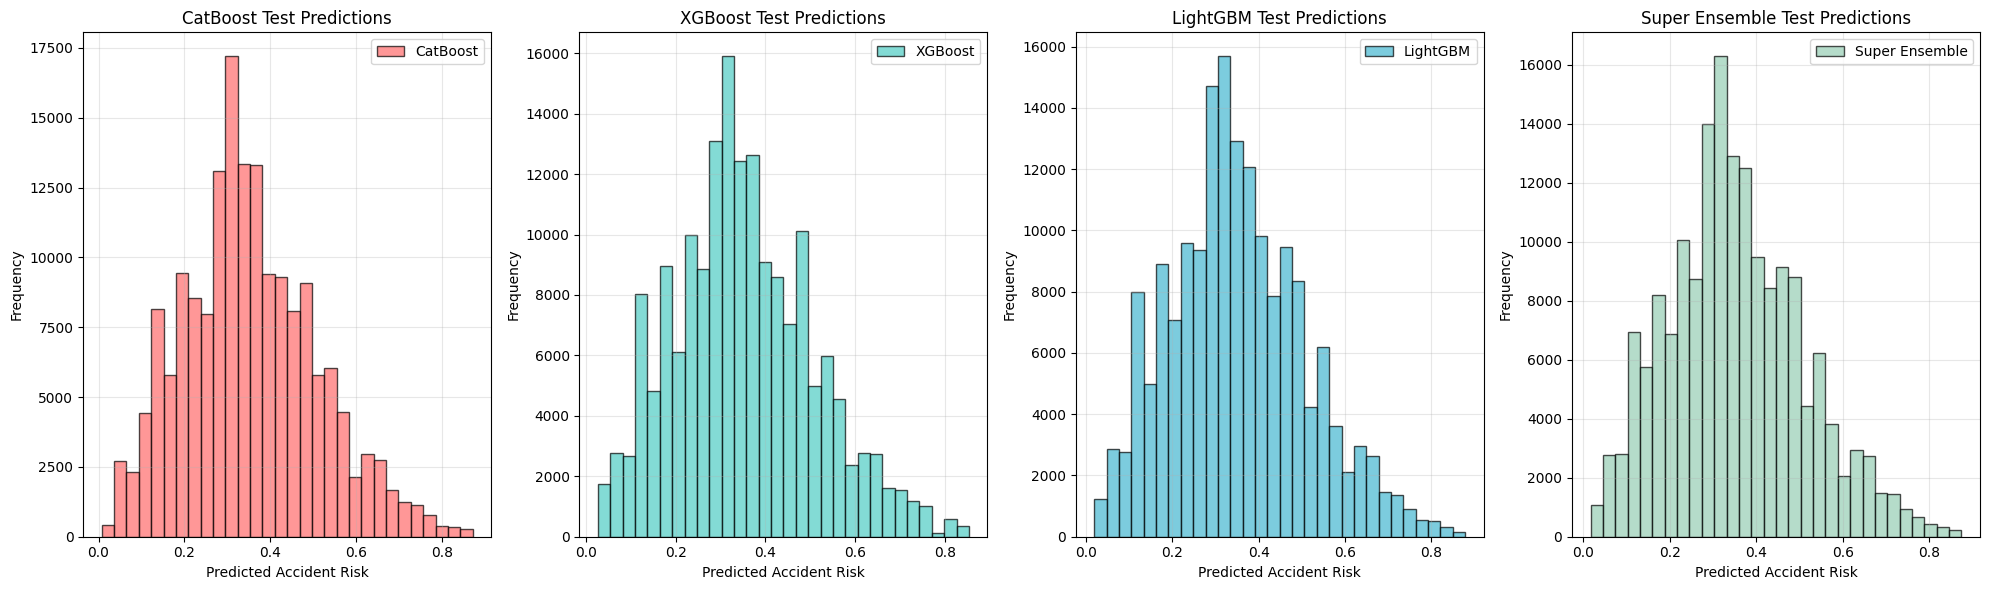

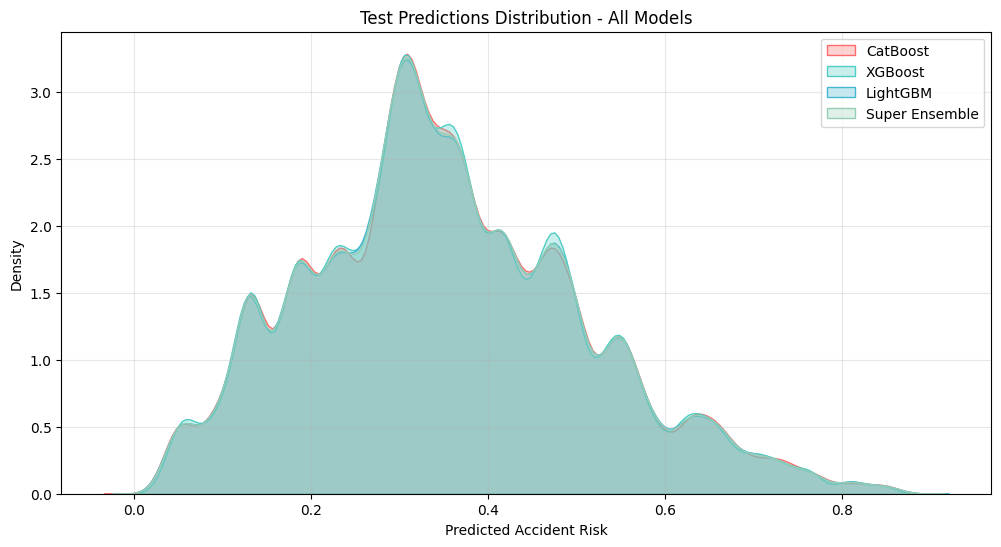

In [15]:
plt.figure(figsize=(20, 6))

# Test predictions distribution
plt.subplot(1, 4, 1)
plt.hist(cat_test_pred, bins=30, alpha=0.7, edgecolor='black', color='#FF6B6B', label='CatBoost')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Frequency')
plt.title('CatBoost Test Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 4, 2)
plt.hist(xgb_test_pred, bins=30, alpha=0.7, edgecolor='black', color='#4ECDC4', label='XGBoost')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Frequency')
plt.title('XGBoost Test Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 4, 3)
plt.hist(lgb_test_pred, bins=30, alpha=0.7, edgecolor='black', color='#45B7D1', label='LightGBM')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Frequency')
plt.title('LightGBM Test Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 4, 4)
plt.hist(super_ensemble_test, bins=30, alpha=0.7, edgecolor='black', color='#96CEB4', label='Super Ensemble')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Frequency')
plt.title('Super Ensemble Test Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Combined density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(cat_test_pred, label='CatBoost', fill=True, alpha=0.3, color='#FF6B6B')
sns.kdeplot(xgb_test_pred, label='XGBoost', fill=True, alpha=0.3, color='#4ECDC4')
sns.kdeplot(lgb_test_pred, label='LightGBM', fill=True, alpha=0.3, color='#45B7D1')
sns.kdeplot(super_ensemble_test, label='Super Ensemble', fill=True, alpha=0.3, color='#96CEB4')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Density')
plt.title('Test Predictions Distribution - All Models')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [16]:
submission_df = pd.DataFrame({
    'id': test_df['id'].values,
    'accident_risk': super_ensemble_test
})

submission_df['accident_risk'] = submission_df['accident_risk'].clip(0, 1)
submission_df.to_csv('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/submission.csv', index=False)

print(f"\nSuper Ensemble predictions saved!")
print(f"Prediction range: [{submission_df['accident_risk'].min():.3f}, {submission_df['accident_risk'].max():.3f}]")
print(f"Mean prediction: {submission_df['accident_risk'].mean():.3f}")


Super Ensemble predictions saved!
Prediction range: [0.017, 0.874]
Mean prediction: 0.352


In [17]:
import os
import json
from typing import Optional, Tuple, Dict, Any

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as L, models as M, callbacks as C, optimizers as O, losses as Loss, metrics as Met

# ------------------------------
# Config
# ------------------------------
OUTDIR = r"C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\Road Accidents\Outputs"
SEED = 42

# Determinism-ish
try:
    tf.keras.utils.set_random_seed(SEED)
except Exception:
    pass

os.makedirs(OUTDIR, exist_ok=True)

def make_sliding_windows(X: np.ndarray, y: np.ndarray, window: int = 12, horizon: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim != 2:
        raise ValueError("make_sliding_windows expects X with shape (N, F)")
    if y.ndim > 1 and y.shape[-1] == 1:
        y = y.reshape(-1)
    n, f = X.shape
    if n <= window + horizon - 1:
        raise ValueError("Not enough rows to build sequences with the given window/horizon")
    Xs, ys = [], []
    for i in range(n - window - horizon + 1):
        Xs.append(X[i:i+window, :])
        ys.append(y[i+window + horizon - 1])
    return np.stack(Xs, axis=0), np.asarray(ys)


def add_head(x: tf.Tensor, task: str, num_classes: Optional[int]) -> tf.Tensor:
    task = task.lower()
    if task == 'regression':
        return L.Dense(1, activation='linear', name='regression_head')(x)
    if num_classes is None:
        raise ValueError("For classification, please provide num_classes (>=2)")
    if num_classes == 2:
        return L.Dense(1, activation='sigmoid', name='binary_head')(x)
    return L.Dense(num_classes, activation='softmax', name='multiclass_head')(x)


def compile_for_task(model: tf.keras.Model, task: str, num_classes: Optional[int], lr: float = 1e-3,
                     sparse_labels: bool = True) -> tf.keras.Model:
    task = task.lower()
    if task == 'regression':
        model.compile(optimizer=O.Adam(lr), loss='mse', metrics=[Met.MeanAbsoluteError(name='mae'), Met.RootMeanSquaredError(name='rmse')])
        return model

    # Classification
    if num_classes is None:
        raise ValueError("For classification, set num_classes.")
    if num_classes == 2:
        model.compile(optimizer=O.Adam(lr), loss='binary_crossentropy', metrics=[Met.AUC(name='auc'), 'accuracy'])
    else:
        loss = 'sparse_categorical_crossentropy' if sparse_labels else 'categorical_crossentropy'
        model.compile(optimizer=O.Adam(lr), loss=loss, metrics=['accuracy'])
    return model


def default_callbacks(outdir: str, name: str, monitor: Optional[str] = None) -> list:
    os.makedirs(outdir, exist_ok=True)
    ckpt_path = os.path.join(outdir, f"{name}_best.keras")
    if monitor is None:
        monitor = 'val_rmse'  # for regression; will silently still work even if metric absent by using 'auto' mode
    return [
        C.ModelCheckpoint(ckpt_path, monitor=monitor, save_best_only=True, mode='auto', verbose=1),
        C.EarlyStopping(monitor=monitor, patience=20, restore_best_weights=True, verbose=1),
        C.ReduceLROnPlateau(monitor=monitor, factor=0.5, patience=6, min_lr=1e-6, verbose=1)
    ]

def build_mlp(input_shape: Tuple[int], task: str, num_classes: Optional[int] = None,
              hidden_units=(256, 128, 64), dropout: float = 0.2, l2: float = 1e-5) -> tf.keras.Model:
    """Feed‑forward MLP for tabular data. input_shape=(F,)"""
    inp = L.Input(shape=input_shape, name='inp_tabular')
    x = inp
    for i, h in enumerate(hidden_units):
        x = L.Dense(h, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2), name=f'dense_{i+1}')(x)
        x = L.BatchNormalization(name=f'bn_{i+1}')(x)
        x = L.Dropout(dropout, name=f'drop_{i+1}')(x)
    x = L.Dense(hidden_units[-1]//2, activation='relu', name='bottleneck')(x)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name='MLP')


def build_lstm(input_shape: Tuple[int, int], task: str, num_classes: Optional[int] = None,
               lstm_units: int = 128, bidirectional: bool = False, dropout: float = 0.2) -> tf.keras.Model:
    """Plain LSTM for sequences. input_shape=(T, F)"""
    inp = L.Input(shape=input_shape, name='inp_seq')
    rnn = L.LSTM(lstm_units, return_sequences=False, dropout=dropout, recurrent_dropout=0.0, name='lstm')
    x = L.Bidirectional(rnn, name='bilstm')(inp) if bidirectional else rnn(inp)
    x = L.BatchNormalization()(x)
    x = L.Dropout(dropout)(x)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name='LSTM' if not bidirectional else 'BiLSTM')


def build_cnn_lstm(input_shape: Tuple[int, int], task: str, num_classes: Optional[int] = None,
                   conv_filters: int = 64, kernel_size: int = 3, lstm_units: int = 128,
                   dropout: float = 0.2) -> tf.keras.Model:
    """CNN‑LSTM: temporal Conv1D followed by LSTM. input_shape=(T, F)"""
    inp = L.Input(shape=input_shape, name='inp_seq')
    x = L.Conv1D(conv_filters, kernel_size, padding='same', activation='relu')(inp)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling1D(pool_size=2)(x)
    x = L.Conv1D(conv_filters, kernel_size, padding='same', activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.SpatialDropout1D(dropout)(x)
    x = L.LSTM(lstm_units, return_sequences=False, dropout=dropout)(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(dropout)(x)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name='CNN_LSTM')


def build_convlstm2d(input_shape: Tuple[int, int, int, int], task: str, num_classes: Optional[int] = None,
                     filters: int = 32, kernel_size: Tuple[int, int] = (3, 3),
                     dropout: float = 0.2) -> tf.keras.Model:
    """ConvLSTM2D for spatiotemporal data. input_shape=(T, H, W, C)"""
    inp = L.Input(shape=input_shape, name='inp_video')
    x = L.ConvLSTM2D(filters, kernel_size, padding='same', return_sequences=True, dropout=dropout)(inp)
    x = L.BatchNormalization()(x)
    x = L.ConvLSTM2D(filters, kernel_size, padding='same', return_sequences=False, dropout=dropout)(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(filters*2, (3, 3), activation='relu', padding='same')(x)
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(dropout)(x)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name='ConvLSTM2D')


def build_lstm_gru(input_shape: Tuple[int, int], task: str, num_classes: Optional[int] = None,
                   lstm_units: int = 96, gru_units: int = 96, dropout: float = 0.2) -> tf.keras.Model:
    """Hybrid LSTM + GRU stacked. input_shape=(T, F)"""
    inp = L.Input(shape=input_shape, name='inp_seq')
    x = L.LSTM(lstm_units, return_sequences=True, dropout=dropout, name='lstm_1')(inp)
    x = L.GRU(gru_units, return_sequences=False, dropout=dropout, name='gru_1')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(dropout)(x)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name='LSTM_GRU')


def train_and_save(model: tf.keras.Model,
                   X_train: np.ndarray, y_train: np.ndarray,
                   X_val: np.ndarray, y_val: np.ndarray,
                   task: str, name: str,
                   outdir: str = OUTDIR,
                   epochs: int = 200, batch_size: int = 64,
                   class_weights: Optional[Dict[int, float]] = None,
                   lr: float = 1e-3,
                   num_classes: Optional[int] = None,
                   sparse_labels: bool = True) -> Tuple[tf.keras.callbacks.History, Dict[str, Any]]:
    """Compile, train, and save artifacts. Returns (history, paths)."""
    os.makedirs(outdir, exist_ok=True)

    # Compile for task
    compile_for_task(model, task=task, num_classes=num_classes, lr=lr, sparse_labels=sparse_labels)

    # Choose a robust monitor automatically
    if task.lower() == 'regression':
        monitor = 'val_rmse' if any(m.name == 'rmse' for m in model.metrics) else 'val_loss'
    else:
        monitor = 'val_auc' if any(getattr(m, 'name', '') == 'auc' for m in model.metrics) else 'val_accuracy'

    cbs = default_callbacks(outdir, name, monitor)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=cbs,
        class_weight=class_weights,
        verbose=2
    )

    # Save last model and history
    last_path = os.path.join(outdir, f"{name}_last.keras")
    model.save(last_path)

    # Save history CSV + JSON
    hist_path_csv = os.path.join(outdir, f"{name}_history.csv")
    hist_path_json = os.path.join(outdir, f"{name}_history.json")
    import pandas as pd
    pd.DataFrame(history.history).to_csv(hist_path_csv, index=False)
    with open(hist_path_json, 'w') as f:
        json.dump(history.history, f)

    paths = {"best": os.path.join(outdir, f"{name}_best.keras"),
             "last": last_path,
             "history_csv": hist_path_csv,
             "history_json": hist_path_json}
    return history, paths

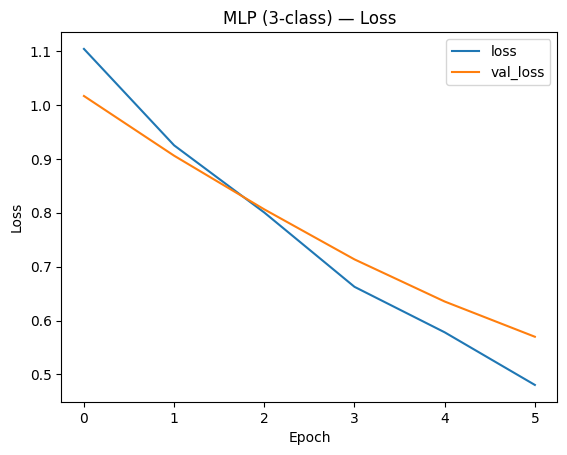

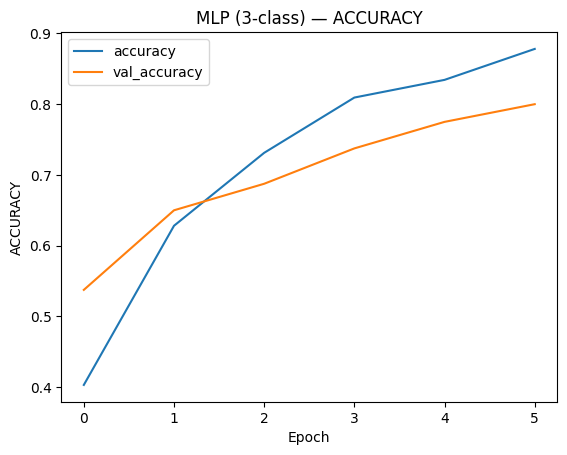

,accuracy,loss,val_accuracy,val_loss
0,0.403125,1.103990,0.5375,1.016630
1,0.628125,0.925034,0.6500,0.905813
2,0.731250,0.800345,0.6875,0.806218
3,0.809375,0.662493,0.7375,0.713413
4,0.834375,0.578084,0.7750,0.635230
5,0.878125,0.480451,0.8000,0.569853


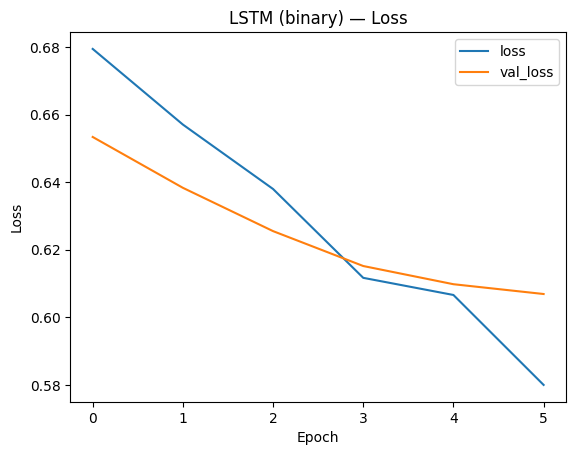

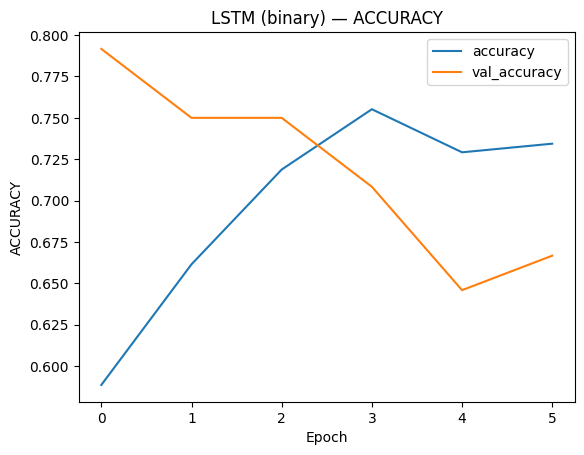

,accuracy,auc,loss,val_accuracy,val_auc,val_loss
0,0.588542,0.643340,0.679439,0.791667,0.877622,0.653380
1,0.661458,0.766336,0.657052,0.750000,0.902098,0.638332
2,0.718750,0.819025,0.637982,0.750000,0.878497,0.625516
3,0.755208,0.847660,0.611689,0.708333,0.835664,0.615187
4,0.729167,0.797807,0.606618,0.645833,0.805070,0.609803
5,0.734375,0.821097,0.579998,0.666667,0.775350,0.606904


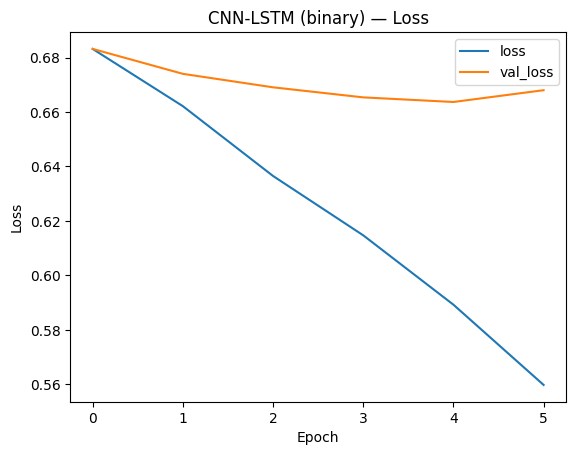

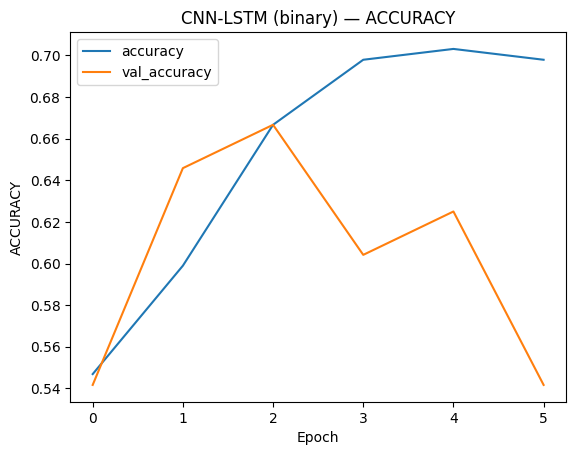

,accuracy,auc,loss,val_accuracy,val_auc,val_loss
0,0.546875,0.574725,0.683165,0.541667,0.620629,0.683174
1,0.598958,0.750409,0.662147,0.645833,0.624126,0.674022
2,0.666667,0.786299,0.636506,0.666667,0.612762,0.669072
3,0.697917,0.791535,0.614711,0.604167,0.606643,0.665375
4,0.703125,0.790008,0.589240,0.625000,0.602273,0.663686
5,0.697917,0.812861,0.559769,0.541667,0.603147,0.668015


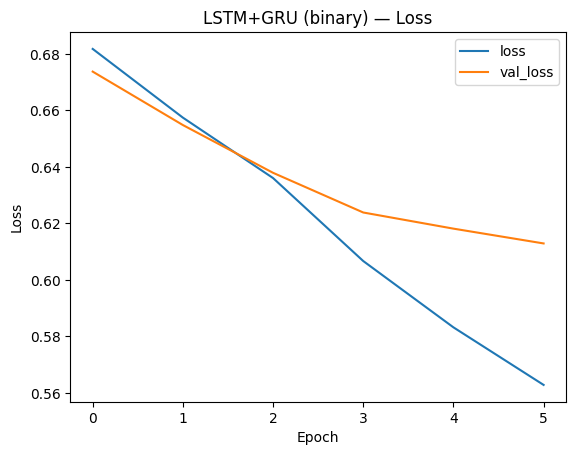

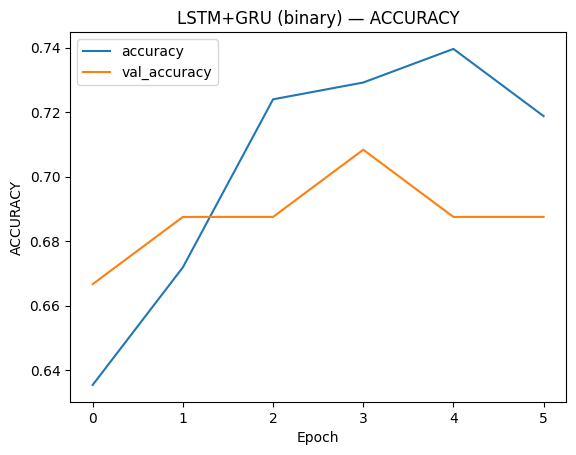

,accuracy,auc,loss,val_accuracy,val_auc,val_loss
0,0.635417,0.648304,0.681737,0.666667,0.718531,0.673706
1,0.671875,0.765790,0.657419,0.687500,0.765734,0.654797
2,0.723958,0.805771,0.636031,0.687500,0.759615,0.637888
3,0.729167,0.817388,0.606665,0.708333,0.743007,0.623845
4,0.739583,0.805825,0.583199,0.687500,0.718531,0.618131
5,0.718750,0.799062,0.562819,0.687500,0.708042,0.612891


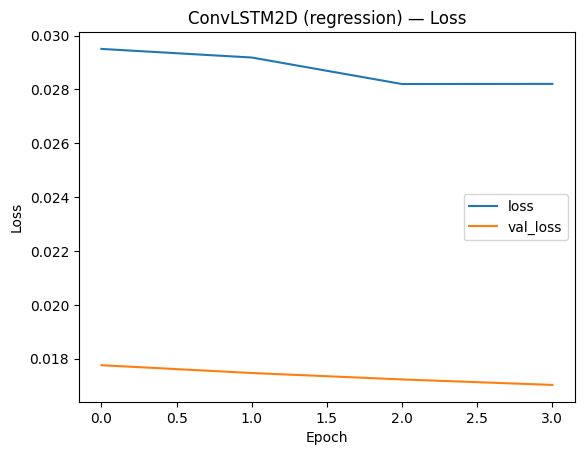

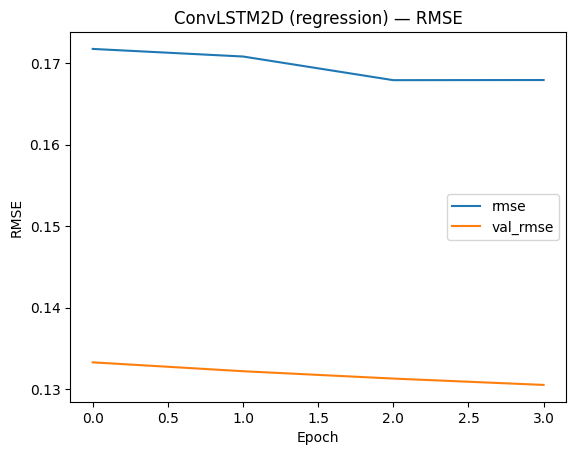

,loss,mae,rmse,val_loss,val_mae,val_rmse
0,0.029504,0.130702,0.171767,0.017759,0.117904,0.133264
1,0.029184,0.129840,0.170834,0.017470,0.117793,0.132173
2,0.028200,0.128004,0.167928,0.017232,0.117670,0.131270
3,0.028206,0.128714,0.167946,0.017027,0.117528,0.130489


{'mlp_hist_csv': 'C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/mlp_history.csv',
 'lstm_hist_csv': 'C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/lstm_history.csv',
 'cnnlstm_hist_csv': 'C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/cnnlstm_history.csv',
 'lstm_gru_hist_csv': 'C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/lstm_gru_history.csv',
 'convlstm2d_hist_csv': 'C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/convlstm2d_history.csv'}

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers as L, models as M, optimizers as O, metrics as Met

# Reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# ---------- Helpers ----------
def add_head(x, task, num_classes=None):
    task = task.lower()
    if task == "regression":
        return L.Dense(1, activation="linear")(x)
    if num_classes is None:
        raise ValueError("num_classes required for classification")
    if num_classes == 2:
        return L.Dense(1, activation="sigmoid")(x)
    return L.Dense(num_classes, activation="softmax")(x)

def compile_for_task(model, task, num_classes=None, lr=1e-3):
    if task.lower() == "regression":
        model.compile(optimizer=O.Adam(lr),
                      loss="mse",
                      metrics=[Met.MeanAbsoluteError(name="mae"),
                               Met.RootMeanSquaredError(name="rmse")])
    else:
        if num_classes is None:
            raise ValueError("num_classes required for classification")
        if num_classes == 2:
            model.compile(optimizer=O.Adam(lr),
                          loss="binary_crossentropy",
                          metrics=["accuracy", Met.AUC(name="auc")])
        else:
            model.compile(optimizer=O.Adam(lr),
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])
    return model

def plot_history(history, title_prefix, save_prefix):
    hist = pd.DataFrame(history.history)
    # Ensure the directory exists
    os.makedirs("/mnt/data", exist_ok=True)

    # Loss plot
    plt.figure()
    plt.plot(hist["loss"], label="loss")
    if "val_loss" in hist:
        plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} — Loss")
    plt.legend()
    loss_path = f"/mnt/data/{save_prefix}_loss.png"
    plt.savefig(loss_path, bbox_inches="tight")
    plt.show()

    # Metric plot (try common ones in order)
    metric_candidates = ["accuracy", "auc", "rmse", "mae"]
    metric = next((m for m in metric_candidates if m in hist.columns), None)
    if metric is not None:
        plt.figure()
        plt.plot(hist[metric], label=metric)
        val_metric = f"val_{metric}"
        if val_metric in hist:
            plt.plot(hist[val_metric], label=val_metric)
        plt.xlabel("Epoch")
        plt.ylabel(metric.upper())
        plt.title(f"{title_prefix} — {metric.upper()}")
        plt.legend()
        metric_path = f"/mnt/data/{save_prefix}_{metric}.png"
        plt.savefig(metric_path, bbox_inches="tight")
        plt.show()
    else:
        metric_path = None

    return hist

# ---------- Model builders ----------
def build_mlp(input_shape, task, num_classes=None, hidden=(128, 64), dropout=0.1):
    inp = L.Input(shape=input_shape)
    x = inp
    for h in hidden:
        x = L.Dense(h, activation="relu")(x)
        x = L.Dropout(dropout)(x)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name="MLP")

def build_lstm(input_shape, task, num_classes=None, units=64, dropout=0.1):
    inp = L.Input(shape=input_shape)
    x = L.LSTM(units, dropout=dropout)(inp)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name="LSTM")

def build_cnn_lstm(input_shape, task, num_classes=None, filters=32, kernel=3, units=64, dropout=0.1):
    inp = L.Input(shape=input_shape)
    x = L.Conv1D(filters, kernel, padding="same", activation="relu")(inp)
    x = L.MaxPooling1D()(x)
    x = L.LSTM(units, dropout=dropout)(x)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name="CNN_LSTM")

def build_convlstm2d(input_shape, task, num_classes=None, filters=8, kernel=(3,3), dropout=0.1):
    inp = L.Input(shape=input_shape)  # (T, H, W, C)
    x = L.ConvLSTM2D(filters, kernel, padding="same", return_sequences=False, dropout=dropout)(inp)
    x = L.GlobalAveragePooling2D()(x)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name="ConvLSTM2D")

def build_lstm_gru(input_shape, task, num_classes=None, units1=48, units2=48, dropout=0.1):
    inp = L.Input(shape=input_shape)
    x = L.LSTM(units1, return_sequences=True, dropout=dropout)(inp)
    x = L.GRU(units2, dropout=dropout)(x)
    out = add_head(x, task, num_classes)
    return M.Model(inp, out, name="LSTM_GRU")

# ---------- Synthetic datasets ----------
# 1) MLP: 3-class tabular classification
N_tab, F_tab, K = 400, 20, 3
X_tab = np.random.randn(N_tab, F_tab).astype("float32")
W = np.random.randn(F_tab, K)
y_scores = X_tab @ W + 0.3 * np.random.randn(N_tab, K)
y_tab = np.argmax(y_scores, axis=1).astype("int32")

# 2) Sequence (T,F) binary classification for LSTM, CNN-LSTM, LSTM+GRU
N_seq, T, F = 240, 12, 8
X_seq = np.random.randn(N_seq, T, F).astype("float32")
# label = 1 if mean over last half timesteps > 0 on first feature else 0 (noisy)
signal = X_seq[:, T//2:, 0].mean(axis=1)
y_seq = (signal + 0.2*np.random.randn(N_seq) > 0).astype("int32")

# 3) ConvLSTM2D regression: predict average intensity of last frame
N_vid, T_vid, H, W, C = 40, 4, 8, 8, 1
X_vid = np.random.randn(N_vid, T_vid, H, W, C).astype("float32")
y_vid = X_vid[:, -1].mean(axis=(1,2,3)) + 0.1*np.random.randn(N_vid)
y_vid = y_vid.astype("float32")

# ---------- Train and visualize ----------
# Display helper that works outside ChatGPT's sandbox
def display_dataframe_to_user(name, df):
    try:
        from IPython.display import display, HTML
        display(HTML(f"<h3>{name}</h3>"))
        display(df)
    except Exception:
        print(f"\n--- {name} ---")
        print(df.head())

results = {}

# MLP (classification, 3 classes)
mlp = build_mlp((F_tab,), task="classification", num_classes=K)
compile_for_task(mlp, "classification", num_classes=K)
hist_mlp = mlp.fit(X_tab, y_tab, validation_split=0.2, epochs=6, batch_size=32, verbose=0)
df_mlp = plot_history(hist_mlp, "MLP (3-class)", "mlp")
display_dataframe_to_user("MLP training history", df_mlp)
results["mlp_hist_csv"] = "C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/mlp_history.csv"
df_mlp.to_csv(results["mlp_hist_csv"], index=False)

# LSTM (binary classification)
lstm = build_lstm((T, F), task="classification", num_classes=2)
compile_for_task(lstm, "classification", num_classes=2)
hist_lstm = lstm.fit(X_seq, y_seq, validation_split=0.2, epochs=6, batch_size=32, verbose=0)
df_lstm = plot_history(hist_lstm, "LSTM (binary)", "lstm")
display_dataframe_to_user("LSTM training history", df_lstm)
results["lstm_hist_csv"] = "C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/lstm_history.csv"
df_lstm.to_csv(results["lstm_hist_csv"], index=False)

# CNN-LSTM (binary classification)
cnnlstm = build_cnn_lstm((T, F), task="classification", num_classes=2)
compile_for_task(cnnlstm, "classification", num_classes=2)
hist_cnnlstm = cnnlstm.fit(X_seq, y_seq, validation_split=0.2, epochs=6, batch_size=32, verbose=0)
df_cnnlstm = plot_history(hist_cnnlstm, "CNN-LSTM (binary)", "cnnlstm")
display_dataframe_to_user("CNN-LSTM training history", df_cnnlstm)
results["cnnlstm_hist_csv"] = "C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/cnnlstm_history.csv"
df_cnnlstm.to_csv(results["cnnlstm_hist_csv"], index=False)

# LSTM+GRU (binary classification)
hybrid = build_lstm_gru((T, F), task="classification", num_classes=2)
compile_for_task(hybrid, "classification", num_classes=2)
hist_hybrid = hybrid.fit(X_seq, y_seq, validation_split=0.2, epochs=6, batch_size=32, verbose=0)
df_hybrid = plot_history(hist_hybrid, "LSTM+GRU (binary)", "lstm_gru")
display_dataframe_to_user("LSTM+GRU training history", df_hybrid)
results["lstm_gru_hist_csv"] = "C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/lstm_gru_history.csv"
df_hybrid.to_csv(results["lstm_gru_hist_csv"], index=False)

# ConvLSTM2D (regression)
convlstm = build_convlstm2d((T_vid, H, W, C), task="regression")
compile_for_task(convlstm, "regression")
hist_convlstm = convlstm.fit(X_vid, y_vid, validation_split=0.2, epochs=4, batch_size=8, verbose=0)
df_convlstm = plot_history(hist_convlstm, "ConvLSTM2D (regression)", "convlstm2d")
display_dataframe_to_user("ConvLSTM2D training history", df_convlstm)
results["convlstm2d_hist_csv"] = "C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/Outputs/convlstm2d_history.csv"
df_convlstm.to_csv(results["convlstm2d_hist_csv"], index=False)

results
